In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.integrate import quad
from scipy.optimize import bisect
from numba import njit
from interpolation import interp

In [11]:
class BCG_incomplete_markets:
    # init method or constructor
    def __init__(self,
                chi1    = 0,
                chi2    = 0.9,
                w10     = 0.9,
                w20     = 1.1,
                theta10 = 0.5,
                theta20 = 0.5,
                psi1    = 3,
                psi2    = 3,
                alpha   = 0.6,
                A       = 2.5,
                mu      = -0.025,
                sigma   = 0.4,
                beta    = 0.96,
                bound   = 3,
                Vl      = 0,
                Vh      = 0.5,
                kbot    = 0.01,
                #ktop = (alpha*A)**(1/(1-alpha)),
                ktop    = 0.25,
                bbot    = 0.1,
                btop    = 0.8):
        #=========== Setup ===========#
        # Risk parameters
        self.chi1  = chi1
        self.chi2  = chi2
        # Other parameters
        self.psi1  = psi1
        self.psi2  = psi2
        self.alpha = alpha 
        self.A     = A
        self.mu    = mu 
        self.sigma = sigma
        self.beta  = beta
        self.bound = bound
        # Bounds for firm value, capital, and debt
        self.Vl    = Vl
        self.Vh    = Vh
        self.kbot  = kbot
        #self.kbot = (*A)**(1/(1-))
        self.ktop  = ktop
        self.bbot  = bbot
        self.btop  = btop
        # Utility
        self.u     = njit(lambda c: (c**(1-psi)) / (1-psi))
        # Initial endowments
        self.w10   = w10
        self.w20   = w20
        self.w0    = w10 + w20
        # Initial holdings
        self.theta10 = theta10
        self.theta20 = theta20
        # Endowments at t=1
        self.w11 = njit(lambda epsilon: np.exp(-chi1*mu - 0.5*(chi1**2)*(sigma**2) + chi1*epsilon))
        self.w21 = njit(lambda epsilon: np.exp(-chi2*mu - 0.5*(chi2**2)*(sigma**2) + chi2*epsilon))
        self.w1  = njit(lambda epsilon: self.w11(epsilon) + self.w21(epsilon))
        # Truncated normal
        ta, tb = (-bound - mu) / sigma , (bound - mu) / sigma 
        rv = truncnorm(ta, tb, loc=mu, scale=sigma)
        eps_range = np.linspace(ta, tb, 1000000)
        pdf_range = rv.pdf(eps_range)
        self.g = njit(lambda epsilon: interp(eps_range, pdf_range, epsilon ))
    #*************************************************************
    # Function: Solve for equilibrium of the BCG model
    #*************************************************************
    def solve_eq(self, print_crit=True):
        # Load parameters
        psi1    = self.psi1
        psi2    = self.psi2
        alpha   = self.alpha
        A       = self.A
        beta    = self.beta
        bound   = self.bound
        Vl      = self.Vl
        Vh      = self.Vh
        kbot    = self.kbot
        ktop    = self.ktop
        bbot    = self.bbot
        btop    = self.btop
        w10     = self.w10
        w20     = self.w20
        theta10 = self.theta10
        theta20 = self.theta20
        w11     = self.w11
        w21     = self.w21
        g       = self.g

        # We need to find a fixed point on the value of the firm
        V_crit = 1

        Y      = njit(lambda epsilon, fk: np.exp(epsilon)*fk)
        intqq1 = njit(lambda epsilon, fk, theta1, psi1, b: (w11(epsilon) + theta1*(Y(epsilon, fk) - b))**(-psi1)*(Y(epsilon, fk) - b)*g(epsilon))
        intp1  = njit(lambda epsilon, fk, psi2, b: (Y(epsilon, fk)/b)*(w21(epsilon) + Y(epsilon, fk))**(-psi2)*g(epsilon))
        intp2  = njit(lambda epsilon, fk, theta2, psi2, b: (w21(epsilon) + theta2*(Y(epsilon, fk)-b) + b)**(-psi2)*g(epsilon))
        intqq2 = njit(lambda epsilon, fk, theta2, psi2, b: (w21(epsilon) + theta2*(Y(epsilon, fk)-b) + b)**(-psi2)*(Y(epsilon, fk) - b)*g(epsilon))
        intk1  = njit(lambda epsilon, fk, psi2: (w21(epsilon) + Y(epsilon, fk))**(-psi2)*np.exp(epsilon)*g(epsilon))
        intk2  = njit(lambda epsilon, fk, theta2, psi2, b: (w21(epsilon) + theta2*(Y(epsilon, fk)-b) + b)**(-psi2)*np.exp(epsilon)*g(epsilon))
        intB1  = njit(lambda epsilon, fk, theta1, psi1, b: (w11(epsilon) + theta1*(Y(epsilon, fk) - b))**(-psi1)*g(epsilon))
        intB2  = njit(lambda epsilon, fk, theta2, psi2, b: (w21(epsilon) + theta2*(Y(epsilon, fk) - b) + b)**(-psi2)*g(epsilon))
        while V_crit>1e-4:
            # We begin by adding the guess for the value of the firm to endowment
            V = (Vl+Vh)/2
            ww10 = w10 + theta10*V
            ww20 = w20 + theta20*V
            # Figure out the optimal level of debt
            bl = bbot
            bh = btop
            b_crit=1
            while b_crit>1e-5:
                # Setting the conjecture for debt
                b = (bl+bh)/2
                # Figure out the optimal level of capital
                kl = kbot
                kh = ktop
                k_crit=1
                while k_crit>1e-5:
                    # Setting the conjecture for capital
                    k = (kl+kh)/2
                    # Production
                    fk = A*(k**alpha)
                    # Y = lambda : np.exp()*fk
                    # Compute integration threshold
                    epstar = np.log(b/fk)
                    #**************************************************************
                    # Compute the prices and allocations consistent with consumers'
                    # Euler equations
                    #**************************************************************
                    # We impose the following:
                    # Agent 1 buys equity
                    # Agent 2 buys equity and all debt
                    # Agents trade such that prices converge
                    #========
                    # Agent 1
                    #========
                    # Holdings
                    xi1 = 0
                    theta1a = 0.3
                    theta1b = 1
                    while abs(theta1b - theta1a) > 0.001:
                        theta1 = (theta1a + theta1b) / 2
                        # qq1 is the equity price consistent with agent-1 Euler␣Equation
                        ## Note: Price is in the date-0 budget constraint of the agent
                        ## First, compute the constant term that is not influenced by␣q
                        ## that is, E[u'(c^{1}_{1})d^{e}(k,B)]
                        # intqq1 = lambda : (w11(epsilon) + 1*(Y(epsilon, fk) - b))**(-1)*(Y(epsilon,fk) - b)*g(epsilon)
                        # const_qq1 =  beta * quad(intqq1,epstar,bound)[0]
                        const_qq1 = beta * quad(intqq1,epstar,bound, args=(fk, theta1, psi1,b))[0]
                        ## Second, iterate to get the equity price q
                        qq1l = 0
                        qq1h = ww10
                        diff = 1
                        while diff > 1e-7:
                            qq1 = (qq1l+qq1h)/2
                            rhs = const_qq1/((ww10-qq1*theta1)**(-psi1))
                            if (rhs > qq1):
                                qq1l = qq1
                            else:
                                qq1h = qq1
                            diff = abs(qq1l-qq1h)
                        #========
                        # Agent 2
                        #========
                        xi2 = b - xi1
                        theta2 = 1 - theta1
                        # p is the bond price consistent with agent-2 Euler Equation
                        ## Note: Price is in the date-0 budget constraint of the agent
                        ## First, compute the constant term that is not influenced by␣
                        ## that is, E[u'(c^{2}_{1})d^{b}(k,B)]
                        # intp1 = lambda : (Y(, fk)/b)*(w21() + Y(, fk))**(-2)*g()
                        # intp2 = lambda : (w21() + 2*(Y(, fk)-b) + b)**(-2)*g()
                        # const_p =  * (quad(intp1,-bound,epstar)[0] + quad(intp2,epstar,bound)[0])
                        const_p =  beta * (quad(intp1,-bound,epstar, args=(fk, psi2, b))[0]\
                                            + quad(intp2,epstar,bound, args=(fk, theta2, psi2,b))[0])
                        ## iterate to get the bond price p
                        pl = 0
                        ph = ww20/b
                        diff = 1
                        while diff > 1e-7:
                            p = (pl+ph)/2
                            rhs = const_p/((ww20-qq1*theta2-p*b)**(-psi2))
                            if (rhs > p):
                                pl = p
                            else:
                                ph = p
                            diff = abs(pl-ph)
                        # qq2 is the equity price consistent with agent-2 Euler␣Equation
                        # intqq2 = lambda : (w21() + 2*(Y(, fk)-b) + b)**(-2)*(Y(, fk) - b)*g()
                        const_qq2 =  beta * quad(intqq2,epstar,bound, args=(fk, theta2, psi2,b))[0]
                        qq2l = 0
                        qq2h = ww20
                        diff = 1
                        while diff > 1e-7:
                            qq2 = (qq2l+qq2h)/2
                            rhs = const_qq2/((ww20-qq2*theta2-p*b)**(-psi2))
                            if (rhs > qq2):
                                qq2l = qq2
                            else:
                                qq2h = qq2
                            diff = abs(qq2l-qq2h)
                        # q be the maximum valuation for the equity among agents
                        ## This will be the equity price based on Makowski's criterion
                        q = max(qq1,qq2)
                        #================
                        # Update holdings
                        #================
                        if qq1 > qq2:
                            theta1a = theta1
                        else:
                            theta1b = theta1
                    #================
                    # Get consumption
                    #================
                    c10 = ww10 - q*theta1
                    c11 = lambda epsilon: w11(epsilon) + theta1*max(Y(epsilon, fk)-b,0)
                    c20 = ww20 - q*(1-theta1) - p*b
                    c21 = lambda epsilon: w21(epsilon) + (1-theta1)*max(Y(epsilon, fk)-b,0) + min(Y(epsilon, fk),b)
                    #*************************************************
                    # Compute the first order conditions for the firm
                    #*************************************************
                    #===========
                    # Equity FOC
                    #===========
                    # Only agent 2's IMRS is relevent
                    # intk1 = lambda epsilon: (w21(epsilon) + Y(epsilon, fk))**(-psi2)*np.exp(epsilon)*g(epsilon)
                    # intk2 = lambda epsilon: (w21(epsilon) + theta2*(Y(epsilon, fk)-b) + b)**(-psi2)*np.exp(epsilon)*g(epsilon)
                    # kfoc_num = quad(intk1,-bound,epstar)[0] + quad(intk2,epstar,bound)[0]
                    kfoc_num = quad(intk1,-bound,epstar, args=(fk, psi2))[0] + quad(intk2,epstar,bound, args=(fk, theta2, psi2, b))[0]
                    kfoc_denom = (ww20- q*theta2 - p*b)**(-psi2)
                    kfoc = beta*alpha*A*(k**(alpha-1))*(kfoc_num/kfoc_denom) - 1
                    if (kfoc > 0):
                        kl = k
                    else:
                        kh = k
                    k_crit = abs(kh-kl)
                    if print_crit:
                        print("critical value of k: {:.5f}".format(k_crit))
                #=========
                # Bond FOC
                #=========
                # intB1 = lambda : (w11() + 1*(Y(, fk) - b))**(-1)*g()
                # intB2 = lambda : (w21() + 2*(Y(, fk) - b) + b)**(-2)*g()
                # bfoc1 = quad(intB1,epstar,bound)[0] / (ww10 - q*1)**(-1)
                # bfoc2 = quad(intB2,epstar,bound)[0] / (ww20 - q*2 - p*b)**(-2)
                bfoc1 = quad(intB1,epstar,bound, args=(fk, theta1, psi1, b))[0] / (ww10 -q*theta1)**(-psi1)
                bfoc2 = quad(intB2,epstar,bound, args=(fk, theta2, psi2, b))[0] / (ww20 -q*theta2 - p*b)**(-psi2)
                bfoc = bfoc1 - bfoc2
                if (bfoc > 0):
                    bh = b
                else:
                    bl = b
                b_crit = abs(bh-bl)
                if print_crit:
                    print("#=== critical value of b: {:.5f}".format(b_crit))
            # Compute the value of the firm
            value_x = -k + q + p*b
            if (value_x > V):
                Vl = V
            else:
                Vh = V
            V_crit = abs(value_x-V)
            if print_crit:
                print("#====== critical value of V: {:.5f}".format(V_crit))
            print('k,b,p,q,kfoc,bfoc,epstar,V,V_crit')
            formattedList = ["%.3f" % member for member in [k,
                                                            b,
                                                            p,
                                                            q,
                                                            kfoc,
                                                            bfoc,
                                                            epstar,
                                                            V,
                                                            V_crit]]
            print(formattedList)
        #*********************************
        # Equilibrium values
        #*********************************
        # Return the results
        kss = k
        bss = b
        Vss = V
        qss = q
        pss = p
        c10ss = c10
        c11ss = c11
        c20ss = c20
        c21ss = c21
        theta1ss = theta1
        # Print the results
        print('finished')
        # print('k,b,p,q,kfoc,bfoc,epstar,V,V_crit')
        #formattedList = ["%.3f" % member for member in [kss,
        # bss,
        # pss,
        # qss,
        # kfoc,
        # bfoc,
        # epstar,
        # Vss,
        # V_crit]]
        #print(formattedList)
        return kss,bss,Vss,qss,pss,c10ss,c11ss,c20ss,c21ss,theta1ss
    #*************************************************************
    # Function: Equity and bond valuations by different agents
    #*************************************************************
    def valuations_by_agent(self,
                            c10, c11, c20, c21,
                            k, b):
        # Load parameters
        psi1    = self.psi1
        psi2    = self.psi2
        alpha   = self.alpha
        A       = self.A
        beta    = self.beta
        bound   = self.bound
        Vl      = self.Vl
        Vh      = self.Vh
        kbot    = self.kbot
        ktop    = self.ktop
        bbot    = self.bbot
        btop    = self.btop
        w10     = self.w10
        w20     = self.w20
        theta10 = self.theta10
        theta20 = self.theta20
        w11     = self.w11
        w21     = self.w21
        g       = self.g
        # Get functions for IMRS/state price density
        IMRS1 = lambda epsilon: beta * (c11(epsilon)/c10)**(-psi1)*g(epsilon)
        IMRS2 = lambda epsilon: beta * (c21(epsilon)/c20)**(-psi2)*g(epsilon)
        # Production
        fk = A*(k**alpha)
        Y = lambda epsilon: np.exp(epsilon)*fk
        # Compute integration threshold
        epstar = np.log(b/fk)
        # Compute equity valuation with agent 1's IMRS
        intQ1 = lambda epsilon: IMRS1(epsilon)*(Y(epsilon) - b)
        Q1 = quad(intQ1, epstar, bound)[0]
        # Compute bond valuation with agent 1's IMRS
        intP1 = lambda epsilon: IMRS1(epsilon)*Y(epsilon)/b
        P1 = quad(intP1, -bound, epstar)[0] + quad(IMRS1, epstar, bound)[0]
        # Compute equity valuation with agent 2's IMRS
        intQ2 = lambda epsilon: IMRS2(epsilon)*(Y(epsilon) - b)
        Q2 = quad(intQ2, epstar, bound)[0]
        # Compute bond valuation with agent 2's IMRS
        intP2 = lambda epsilon: IMRS2(epsilon)*Y(epsilon)/b
        P2 = quad(intP2, -bound, epstar)[0] + quad(IMRS2, epstar, bound)[0]
        return Q1,Q2,P1,P2
    #*************************************************************
    # Function: equilibrium valuations for firm, equity, bond
    #*************************************************************
    def eq_valuation(self, c10, c11, c20, c21, N=30):
        # Load parameters
        psi1    = self.psi1
        psi2    = self.psi2
        alpha   = self.alpha
        A       = self.A
        beta    = self.beta
        bound   = self.bound
        Vl      = self.Vl
        Vh      = self.Vh
        kbot    = self.kbot
        ktop    = self.ktop
        bbot    = self.bbot
        btop    = self.btop
        w10     = self.w10
        w20     = self.w20
        theta10 = self.theta10
        theta20 = self.theta20
        w11     = self.w11
        w21     = self.w21
        g       = self.g
        # Create grids
        kgrid, bgrid = np.meshgrid(np.linspace(kbot,ktop,N),
                                   np.linspace(bbot,btop,N))
        Vgrid = np.zeros_like(kgrid)
        Qgrid = np.zeros_like(kgrid)
        Pgrid = np.zeros_like(kgrid)
        # Loop: firm value
        for i in range(N):
            for j in range(N):
                # Get capital and debt
                k = kgrid[i,j]
                b = bgrid[i,j]
                # Valuations by each agent
                Q1,Q2,P1,P2 = self.valuations_by_agent(c10,
                                                        c11,
                                                        c20,
                                                        c21,
                                                        k,
                                                        b)
                # The prices will be the maximum of the valuations
                Q = max(Q1,Q2)
                P = max(P1,P2)
                # Compute firm value
                V = -k + Q + P*b
                Vgrid[i,j] = V
                Qgrid[i,j] = Q
                Pgrid[i,j] = P
        return kgrid, bgrid, Vgrid, Qgrid, Pgrid

In [12]:
mdl = BCG_incomplete_markets()
#kss,bss,Vss,qss,pss,c10ss,c11ss,c20ss,c21ss,theta1ss = mdl.solve_eq(print_crit=False)

In [13]:
kss,bss,Vss,qss,pss,c10ss,c11ss,c20ss,c21ss,theta1ss = mdl.solve_eq(print_crit=False)
print(-kss+qss+pss*bss)
print(Vss)
print(theta1ss)

k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.178', '0.503', '0.407', '0.092', '0.000', '-0.000', '-0.568', '0.250', '0.131']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.155', '0.487', '0.381', '0.073', '0.000', '0.000', '-0.518', '0.125', '0.021']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.144', '0.479', '0.368', '0.065', '0.000', '0.000', '-0.492', '0.062', '0.034']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.150', '0.484', '0.374', '0.069', '0.000', '-0.000', '-0.504', '0.094', '0.006']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.153', '0.486', '0.377', '0.071', '0.000', '-0.000', '-0.510', '0.109', '0.008']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.484', '0.376', '0.070', '0.000', '0.000', '-0.508', '0.102', '0.001']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.483', '0.375', '0.070', '-0.000', '0.000', '-0.507', '0.098', '0.003']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.484', '0.375', '0.070', '0.000', '-0.000', '-0.507', '0.100', '0.001']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.484', '0.376

In [14]:
kgrid, bgrid, Vgrid, Qgrid, Pgrid = mdl.eq_valuation(c10ss, c11ss, c20ss, c21ss,N=30)
print('Maximum valuation of the firm value in the (k,B) grid: {:.5f}'.format(Vgrid.max()))
print('Equilibrium firm value: {:.5f}'.format(Vss))

Maximum valuation of the firm value in the (k,B) grid: 0.10074
Equilibrium firm value: 0.10083


In [15]:
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objs as go

In [16]:
fig = go.Figure(data=[go.Scatter3d(x=[kss],
y=[bss],
z=[Vss],
mode='markers',
marker=dict(size=3, color='red')),
go.Surface(x=kgrid,
y=bgrid,
z=Vgrid,
colorscale='Blues',opacity=0.6)])
fig.update_layout(scene = dict(
xaxis_title='x - Capital k',
yaxis_title='y - Debt b',
zaxis_title='z - Firm Value V',
aspectratio = dict(x=1,y=1,z=1)),
width=700,
height=700,
margin=dict(l=50, r=50, b=65, t=90))
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=-1.5, z=2)))
fig.update_layout(title='Equilibrium firm valuation for the grid of (k,b)')
# Export to PNG file
# Image(fig.to_image(format="png"))
# fig.show() will provide interactive plot when running
# code locally

In [19]:
def off_eq_check(mdl,kss,bss,e=0.1):
    # Big K and big B
    k       = kss
    b       = bss + e
    # Load parameters
    psi1    = mdl.psi1
    psi2    = mdl.psi2
    alpha   = mdl.alpha
    A       = mdl.A
    beta    = mdl.beta
    bound   = mdl.bound
    Vl      = mdl.Vl
    Vh      = mdl.Vh
    kbot    = mdl.kbot
    ktop    = mdl.ktop
    bbot    = mdl.bbot
    btop    = mdl.btop
    w10     = mdl.w10
    w20     = mdl.w20
    theta10 = mdl.theta10
    theta20 = mdl.theta20
    w11     = mdl.w11
    w21     = mdl.w21
    g       = mdl.g
    Y = njit(lambda epsilon , fk: np.exp(epsilon)*fk)
    intqq1  = njit(lambda epsilon, fk, theta1, psi1, xi1, b: (w11(epsilon) + theta1*(Y(epsilon, fk) - b) + xi1)**(-psi1)*(Y(epsilon, fk) - b)*g(epsilon))
    intpp1a = njit(lambda epsilon, fk, psi1, xi1, b: (Y(epsilon, fk)/b)*(w11(epsilon) + Y(epsilon, fk)/b*xi1)**(-psi1)*g(epsilon))
    intpp1b = njit(lambda epsilon, fk, theta1, psi1, xi1, b: (w11(epsilon) + theta1*(Y(epsilon, fk)-b) + xi1)**(-psi1)*g(epsilon))
    intpp2a = njit(lambda epsilon, fk, psi2, xi2, b: (Y(epsilon, fk)/b)*(w21(epsilon) + Y(epsilon, fk)/b*xi2)**(-psi2)*g(epsilon))
    intpp2b = njit(lambda epsilon, fk, theta2, psi2, xi2, b: (w21(epsilon) + theta2*(Y(epsilon, fk)-b) + xi2)**(-psi2)*g(epsilon))
    intqq2  = njit(lambda epsilon, fk, theta2, psi2, b: (w21(epsilon) + theta2*(Y(epsilon, fk)-b) + b)**(-psi2)*(Y(epsilon, fk) - b)*g(epsilon))
    # Loop: Find fixed points V, q and p
    V_crit = 1
    while V_crit>1e-5:
        # We begin by adding the guess for the value of the firm to endowment
        V = (Vl+Vh)/2
        ww10 = w10 + theta10*V
        ww20 = w20 + theta20*V
        # Production
        fk = A*(k**alpha)
        # Y = lambda : np.exp()*fk
        # Compute integration threshold
        epstar = np.log(b/fk)
        #**************************************************************
        # Compute the prices and allocations consistent with consumers'
        # Euler equations
        #**************************************************************
        # We impose the following:
        # Agent 1 buys equity
        # Agent 2 buys equity and all debt
        # Agents trade such that prices converge
        #========
        # Agent 1
        #========
        # Holdings
        xi1a = 0
        xi1b = b/2
        p = 0.3
        while abs(xi1b - xi1a) > 0.001:
            xi1 = (xi1a + xi1b) / 2
            theta1a = 0.3
            theta1b = 1
            while abs(theta1b - theta1a) > (0.001/b):
                theta1 = (theta1a + theta1b) / 2
                # qq1 is the equity price consistent with agent-1 Euler Equation
                ## Note: Price is in the date-0 budget constraint of the agent
                ## First, compute the constant term that is not influenced by q
                ## that is, E[u'(c^{1}_{1})d^{e}(k,B)]
                # intqq1 = lambda : (w11() + 1*(Y(, fk) - b) + 1)**(-1)*(Y(,fk) - b)*g()
                # const_qq1 =  * quad(intqq1,epstar,bound)[0]
                const_qq1 = beta * quad(intqq1,epstar,bound, args=(fk, theta1, psi1, xi1, b))[0]
                ## Second, iterate to get the equity price q
                qq1l = 0
                qq1h = ww10
                diff = 1
                while diff > 1e-7:
                    qq1 = (qq1l+qq1h)/2
                    rhs = const_qq1/((ww10-qq1*theta1-p*xi1)**(-psi1));
                    if (rhs > qq1):
                        qq1l = qq1
                    else:
                        qq1h = qq1
                    diff = abs(qq1l-qq1h)
                # pp1 is the bond price consistent with agent-2 Euler Equation
                ## Note: Price is in the date-0 budget constraint of the agent
                ## First, compute the constant term that is not influenced by p
                ## that is, E[u'(c^{1}_{1})d^{b}(k,B)]
                # intpp1a = lambda : (Y(, fk)/b)*(w11() + Y(, fk)/b*1)**(-1)*g()
                # intpp1b = lambda : (w11() + 1*(Y(, fk)-b) + 1)**(-1)*g()
                # const_pp1 =  * (quad(intpp1a,-bound,epstar)[0] + quad(intpp1b,epstar,bound)[0])
                const_pp1 = beta * (quad(intpp1a,-bound,epstar, args=(fk, psi1, xi1, b))[0] \
                                    + quad(intpp1b,epstar,bound, args=(fk, theta1, psi1, xi1,b))[0])
                ## iterate to get the bond price p
                pp1l = 0
                pp1h = ww10/b
                diff = 1
                while diff > 1e-7:
                    pp1 = (pp1l+pp1h)/2
                    rhs = const_pp1/((ww10-qq1*theta1-pp1*xi1)**(-psi1))
                    if (rhs > pp1):
                        pp1l = pp1
                    else:
                        pp1h = pp1
                    diff = abs(pp1l-pp1h)
                #========
                # Agent 2
                #========
                xi2 = b - xi1
                theta2 = 1 - theta1
                # pp2 is the bond price consistent with agent-2 Euler Equation
                ## Note: Price is in the date-0 budget constraint of the agent
                ## First, compute the constant term that is not influenced by p
                ## that is, E[u'(c^{2}_{1})d^{b}(k,B)]
                # intpp2a = lambda : (Y(, fk)/b)*(w21() + Y(, fk)/b*2)**(-2)*g()
                # intpp2b = lambda : (w21() + 2*(Y(, fk)-b) + 2)**(-2)*g()
                # const_pp2 =  * (quad(intpp2a,-bound,epstar)[0] + quad(intpp2b,epstar,bound)[0])
                const_pp2 = beta * (quad(intpp2a,-bound,epstar, args=(fk, psi2, xi2, b))[0]\
                                    + quad(intpp2b,epstar,bound, args=(fk, theta2, psi2, xi2,b))[0])
                ## iterate to get the bond price p
                pp2l = 0
                pp2h = ww20/b
                diff = 1
                while diff > 1e-7:
                    pp2 = (pp2l+pp2h)/2
                    rhs = const_pp2/((ww20-qq1*theta2-pp2*xi2)**(-psi2))
                    if (rhs > pp2):
                        pp2l = pp2
                    else:
                        pp2h = pp2
                    diff = abs(pp2l-pp2h)
                # p be the maximum valuation for the bond among agents
                ## This will be the equity price based on Makowski's criterion
                p = max(pp1,pp2)
                # qq2 is the equity price consistent with agent-2 Euler Equation
                # intqq2 = lambda : (w21() + 2*(Y(, fk)-b) + b)**(-2)*(Y(, fk)- b)*g()
                # const_qq2 =  * quad(intqq2,epstar,bound)[0]
                const_qq2 = beta * quad(intqq2,epstar,bound, args=(fk, theta2, psi2, b))[0]
                qq2l = 0
                qq2h = ww20
                diff = 1
                while diff > 1e-7:
                    qq2 = (qq2l+qq2h)/2
                    rhs = const_qq2/((ww20-qq2*theta2-p*xi2)**(-psi2))
                    if (rhs > qq2):
                        qq2l = qq2
                    else:
                        qq2h = qq2
                    diff = abs(qq2l-qq2h)
                # q be the maximum valuation for the equity among agents
                ## This will be the equity price based on Makowski's criterion
                q = max(qq1,qq2)
                #================
                # Update holdings
                #================
                if qq1 > qq2:
                    theta1a = theta1
                else:
                    theta1b = theta1
            #print(p,q,1,1)
            if pp1 > pp2:
                xi1a = xi1
            else:
                xi1b = xi1
        #================
        # Get consumption
        #================
        c10 = ww10 - q*theta1 - p*xi1
        c11 = lambda epsilon: w11(epsilon) + theta1*max(Y(epsilon, fk)-b,0) + xi1*min(Y(epsilon, fk)/b,1)
        c20 = ww20 - q*(1-theta1) - p*(b-xi1)
        c21 = lambda epsilon: w21(epsilon) + (1-theta1)*max(Y(epsilon, fk)-b,0) + (b-xi1)*min(Y(epsilon, fk)/b,1)
        # Compute the value of the firm
        value_x = -k + q + p*b
        if (value_x > V):
            Vl = V
        else:
            Vh = V
        V_crit = abs(value_x-V)
    return V,k,b,p,q,c10,c11,c20,c21,xi1

In [22]:
#====================== Experiment 1 ======================#
Ve1,ke1,be1,pe1,qe1,c10e1,c11e1,c20e1,c21e1,xi1e1 = off_eq_check(mdl,
                                                                kss,
                                                                bss,
                                                                e=-0.1)
# Firm Valuation
kgride1, bgride1, Vgride1, Qgride1, Pgride1 = mdl.eq_valuation(c10e1, c11e1, c20e1,c21e1,N=20)
print('Maximum valuation of the firm value in the (k,b) grid: {:.4f}'.format(Vgride1.max()))
print('Equilibrium firm value: {:.4f}'.format(Ve1))
fig = go.Figure(data=[go.Scatter3d(x=[ke1],
                y=[be1],
                z=[Ve1],
                mode='markers',
                marker=dict(size=3, color='red')),
                go.Surface(x=kgride1,
                y=bgride1,
                z=Vgride1,
                colorscale='Greens',opacity=0.6)])
fig.update_layout(scene = dict(
                    xaxis_title='x - Capital k',
                    yaxis_title='y - Debt b',
                    zaxis_title='z - Firm Value V',
                    aspectratio = dict(x=1,y=1,z=1)),
                width=700,
                height=700,
                margin=dict(l=50, r=50, b=65, t=90))
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=-1.5, z=2)))
fig.update_layout(title='Equilibrium firm valuation for the grid of (k,b)')
# Export to PNG file
# Image(fig.to_image(format="png"))
# fig.show() will provide interactive plot when running
# code locally

Maximum valuation of the firm value in the (k,b) grid: 0.1191
Equilibrium firm value: 0.1118


In [24]:
#====================== Experiment 2 ======================#
Ve2,ke2,be2,pe2,qe2,c10e2,c11e2,c20e2,c21e2,xi1e2 = off_eq_check(mdl,
                                                                kss,bss,
                                                                e=0.1)
# Firm Valuation
kgride2, bgride2, Vgride2, Qgride2, Pgride2 = mdl.eq_valuation(c10e2, c11e2, c20e2,c21e2,N=20)
print('Maximum valuation of the firm value in the (k,b) grid: {:.4f}'.format(Vgride2.max()))
print('Equilibrium firm value: {:.4f}'.format(Ve2))
fig = go.Figure(data=[go.Scatter3d(x=[ke2],
                y=[be2],
                z=[Ve2],
                mode='markers',
                marker=dict(size=3, color='red')),
                go.Surface(x=kgride2,
                y=bgride2,
                z=Vgride2,
                colorscale='blues',opacity=0.6)])
fig.update_layout(scene = dict(
                    xaxis_title='x - Capital k',
                    yaxis_title='y - Debt b',
                    zaxis_title='z - Firm Value V',
                    aspectratio = dict(x=1,y=1,z=1)),
                    width=700,
                    height=700,
                    margin=dict(l=50, r=50, b=65, t=90))
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=-1.5, z=2)))
fig.update_layout(title='Equilibrium firm valuation for the grid of (k,b)')
# Export to PNG file
# Image(fig.to_image(format="png"))
# fig.show() will provide interactive plot when running
# code locally

Maximum valuation of the firm value in the (k,b) grid: 0.1082
Equilibrium firm value: 0.0974


In [26]:
print('Bond holdings of agent 1: {:.3f}'.format(xi1e2))

Bond holdings of agent 1: 0.039


In [29]:
# Equity Valuation
fig = go.Figure(data=[go.Scatter3d(x=[kss],
                y=[bss],
                z=[qss],
                mode='markers',
                marker=dict(size=3, color='red')),
                go.Surface(x=kgrid,
                y=bgrid,
                z=Qgrid,
                colorscale='Purples',opacity=0.6)])
fig.update_layout(scene = dict(
                xaxis_title='x - Capital k',
                yaxis_title='y - Debt b',
                zaxis_title='z - Equity price q',
                aspectratio = dict(x=1,y=1,z=1)),
                width=700,
                height=700,
                margin=dict(l=50, r=50, b=65, t=90))
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=-1.5, z=2)))
fig.update_layout(title='Equilibrium equity valuation for the grid of (k,b)')
# Export to PNG file
# Image(fig.to_image(format="png"))
# fig.show() will provide interactive plot when running
# code locally

In [28]:
# Bond Valuation
fig = go.Figure(data=[go.Scatter3d(x=[kss],
                y=[bss],
                z=[pss],
                mode='markers',
                marker=dict(size=3, color='red')),
                go.Surface(x=kgrid,
                y=bgrid,
                z=Pgrid,
                colorscale='Oranges',opacity=0.6)])
fig.update_layout(scene = dict(
                xaxis_title='x - Capital k',
                yaxis_title='y - Debt b',
                zaxis_title='z - Bond price q',
                aspectratio = dict(x=1,y=1,z=1)),
                width=700,
                height=700,
                margin=dict(l=50, r=50, b=65, t=90))
fig.update_layout(scene_camera=dict(eye=dict(x=1.5, y=-1.5, z=2)))
fig.update_layout(title='Equilibrium bond valuation for the grid of (k,b)')
# Export to PNG file
# Image(fig.to_image(format="png"))
# fig.show() will provide interactive plot when running
# code locally

In [31]:
# Lists for storage
wlist = []
klist = []
blist = []
qlist = []
plist = []
Vlist = []
tlist = []
q1list = []
q2list = []
p1list = []
p2list = []
# For loop: optimization for each endowment combination
for i in range(10):
    print(i)
    # Save fraction
    w10 = 0.9 - 0.05*i
    w20 = 1.1 + 0.05*i
    wlist.append(w20/(w10+w20))
    # Create the instance
    mdl = BCG_incomplete_markets(w10 = w10, w20 = w20, ktop = 0.5, btop = 2.5)
    # Solve for equilibrium
    kss,bss,Vss,qss,pss,c10ss,c11ss,c20ss,c21ss,theta1ss = mdl.solve_eq(print_crit=False)
    # Store the equilibrium results
    klist.append(kss)
    blist.append(bss)
    qlist.append(qss)
    plist.append(pss)
    Vlist.append(Vss)
    tlist.append(theta1ss)

    # Evaluations of equity and bond by each agent
    Q1,Q2,P1,P2 = mdl.valuations_by_agent(c10ss, c11ss, c20ss, c21ss, kss, bss)
    # Save the valuations
    q1list.append(Q1)
    q2list.append(Q2)
    p1list.append(P1)
    p2list.append(P2)

0
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.178', '0.502', '0.407', '0.092', '-0.000', '-0.000', '-0.570', '0.250', '0.131']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.155', '0.487', '0.381', '0.073', '-0.001', '0.000', '-0.518', '0.125', '0.022']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.145', '0.480', '0.367', '0.065', '0.000', '-0.000', '-0.490', '0.062', '0.034']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.150', '0.484', '0.374', '0.069', '0.000', '0.000', '-0.504', '0.094', '0.006']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.153', '0.485', '0.378', '0.071', '0.000', '-0.000', '-0.511', '0.109', '0.008']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.484', '0.376', '0.070', '-0.000', '-0.000', '-0.508', '0.102', '0.001']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.483', '0.375', '0.070', '0.000', '-0.000', '-0.507', '0.098', '0.003']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.484', '0.375', '0.070', '-0.000', '0.000', '-0.506', '0.100', '0.001']
k,b,p,q,kfoc,bfoc,epstar,V,V_crit
['0.151', '0.484', 

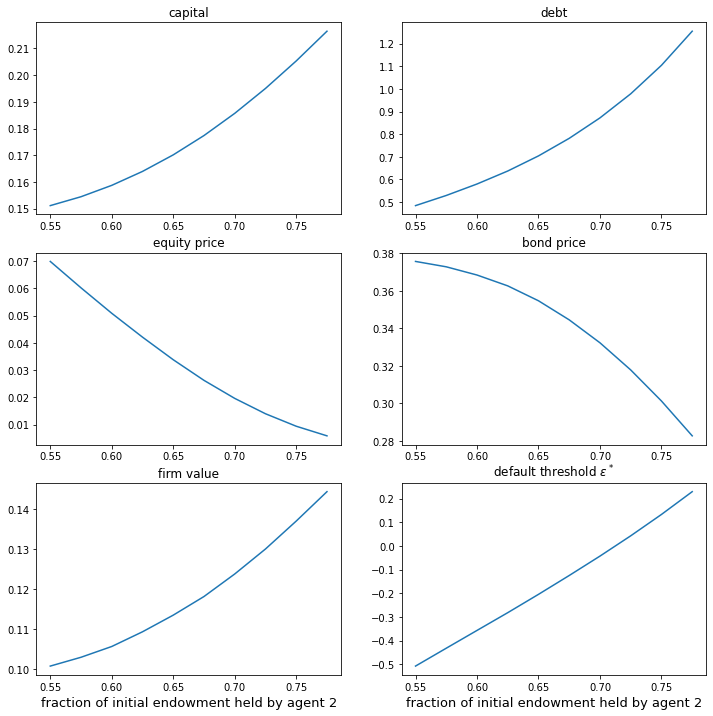

In [36]:
# Plot
fig, ax = plt.subplots(3,2,figsize=(12,12))
ax[0,0].plot(wlist,klist)
ax[0,0].set_title('capital')
ax[0,1].plot(wlist,blist)
ax[0,1].set_title('debt')
ax[1,0].plot(wlist,qlist)
ax[1,0].set_title('equity price')
ax[1,1].plot(wlist,plist)
ax[1,1].set_title('bond price')
ax[2,0].plot(wlist,Vlist)
ax[2,0].set_title('firm value')
ax[2,0].set_xlabel('fraction of initial endowment held by agent 2',fontsize=13)
# Create a list of Default thresholds
A       = mdl.A
alpha   = mdl.alpha
epslist = []
for i in range(len(wlist)):
    bb = blist[i]
    kk = klist[i]
    eps = np.log(bb/(A*kk**alpha))
    epslist.append(eps)
# Plot (cont.)
ax[2,1].plot(wlist,epslist)
ax[2,1].set_title(r'default threshold $\epsilon^*$')
ax[2,1].set_xlabel('fraction of initial endowment held by agent 2',fontsize=13)
plt.show()

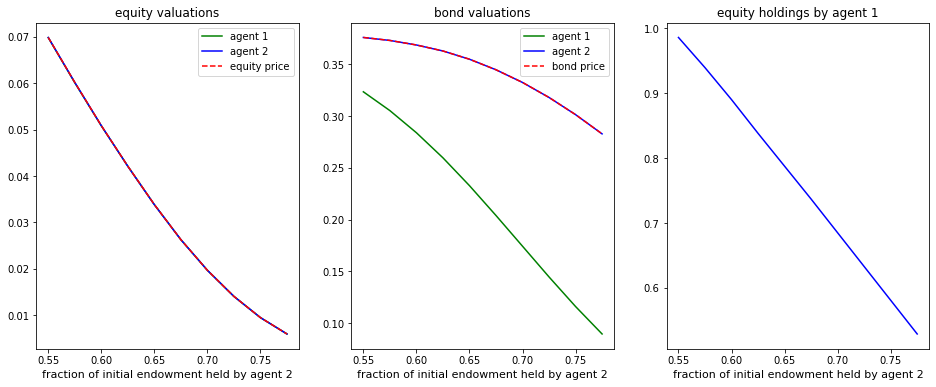

In [37]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].plot(wlist,q1list,label='agent 1',color='green')
ax[0].plot(wlist,q2list,label='agent 2',color='blue')
ax[0].plot(wlist,qlist,label='equity price',color='red',linestyle='--')
ax[0].legend()
ax[0].set_title('equity valuations')
ax[0].set_xlabel('fraction of initial endowment held by agent 2',fontsize=11)
ax[1].plot(wlist,p1list,label='agent 1',color='green')
ax[1].plot(wlist,p2list,label='agent 2',color='blue')
ax[1].plot(wlist,plist,label='bond price',color='red',linestyle='--')
ax[1].legend()
ax[1].set_title('bond valuations')
ax[1].set_xlabel('fraction of initial endowment held by agent 2',fontsize=11)
ax[2].plot(wlist,tlist,color='blue')
ax[2].set_title('equity holdings by agent 1')
ax[2].set_xlabel('fraction of initial endowment held by agent 2',fontsize=11)
plt.show()